In [12]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
import io
import csv
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from stats import mean, median, mode, multi_mode
import warnings
import matplotlib.cbook
from config import api_key

ModuleNotFoundError: No module named 'stats'

In [ ]:
url = "https://opendata.arcgis.com/datasets/8070cd333824453abea19e8faa340fb8_0.geojson"
response = requests.get(url).json()

with open('lightrail_data.txt', 'w') as outfile:
   json.dump(response, outfile)
with open('lightrail_data.txt') as rail_file:
   dict_rail = json.load(rail_file)

rail_data = pd.DataFrame.from_dict(json_normalize(dict_rail['features']), orient='columns')
# Reorganizing the columns using double brackets
organized_rail_df = rail_data[['properties.StationName', 
                               'properties.Q2015_1', 
                               'properties.Q2015_2', 
                               'properties.Q2015_3', 
                               'properties.Q2015_4', 
                               'properties.Q2016_1',
                               'properties.Q2016_2',
                               'properties.Q2106_3',
                               'properties.Q2016_4',
                               'properties.Q2017_1',
                               'properties.Q2017_2',
                               'properties.Q2017_3',
                               'properties.Q2017_4',
                               'geometry.coordinates', 
                               'properties.Jurisdiction',
                               'properties.Type']]

In [ ]:
renamed_rail_df = organized_rail_df.rename(columns={'properties.StationName': 'Station Name', 
                                               'properties.Q2015_1': '2015 Q1', 
                                               'properties.Q2015_2': '2015 Q2', 
                                               'properties.Q2015_3': '2015 Q3', 
                                               'properties.Q2015_4': '2015 Q4', 
                                               'properties.Q2016_1': '2016 Q1',
                                               'properties.Q2016_2': '2016 Q2',
                                               'properties.Q2106_3': '2016 Q3',
                                               'properties.Q2016_4': '2016 Q4',
                                               'properties.Q2017_1': '2017 Q1',
                                               'properties.Q2017_2': '2017 Q2',
                                               'properties.Q2017_3': '2017 Q3',
                                               'properties.Q2017_4': '2017 Q4',
                                               'geometry.coordinates': 'Stop Locations', 
                                               'properties.Jurisdiction': 'Local Municipality',
                                               'properties.Type': 'Eastbound or Westbound'})

# Replacing Boardings and Departures with proper directional naming conventions
renamed_rail_df.loc[:,'Eastbound or Westbound'] = renamed_rail_df['Eastbound or Westbound'].str.replace('Boardings', 'Eastbound').str.replace('Departures', 'Westbound')  

In [ ]:
# Removing brackets from geometry.coordinates, splitting into lat/lon columns
renamed_rail_df['Locations'] = renamed_rail_df['Stop Locations'].astype(str).str.replace('\[|\]','')

# # Creating lat/lon lists
lat = []
lon = []
for row in renamed_rail_df['Locations']:
   lat.append(row.split(',')[1])
   lon.append(row.split(',')[0])
    
# appending lat and lon data to new columns in dataframe
renamed_rail_df['Latitude'] = lat
renamed_rail_df['Longitude'] = lon

# Dropping unnecessary columns
renamed_rail_df = renamed_rail_df.drop(columns=['Stop Locations', 'Locations'])
renamed_rail_df.head()

In [ ]:
# What is light rail rider volume by quarter from 2015 to 2017?
quarters = ['2015 Q1','2015 Q2','2015 Q3','2015 Q4','2016 Q1','2016 Q2',
            '2016 Q3','2016 Q4','2017 Q1','2017 Q2','2017 Q3','2017 Q4',]

passenger_volume = []

passenger_volume.append(renamed_rail_df['2015 Q1'].sum())
passenger_volume.append(renamed_rail_df['2015 Q2'].sum())
passenger_volume.append(renamed_rail_df['2015 Q3'].sum())
passenger_volume.append(renamed_rail_df['2015 Q4'].sum())
passenger_volume.append(renamed_rail_df['2016 Q1'].sum())
passenger_volume.append(renamed_rail_df['2016 Q2'].sum())
passenger_volume.append(renamed_rail_df['2016 Q3'].sum())
passenger_volume.append(renamed_rail_df['2016 Q4'].sum())
passenger_volume.append(renamed_rail_df['2017 Q1'].sum())
passenger_volume.append(renamed_rail_df['2017 Q2'].sum())
passenger_volume.append(renamed_rail_df['2017 Q3'].sum())
passenger_volume.append(renamed_rail_df['2017 Q4'].sum())
passenger_volume
quarterly_riders_df = pd.DataFrame(quarters , passenger_volume)

quarter_totals = {'Quarters':quarters, 'Passenger Volume':passenger_volume}
quarter_totals_df = pd.DataFrame(quarter_totals)
quarter_totals_df

In [ ]:
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
x_pos = [i for i, _ in enumerate(quarters)]
plt.xlim(60000, 97000)

plt.barh(x_pos, passenger_volume, color='green')
plt.ylabel('Quarters')
plt.xlabel('Passenger Volume')
plt.title('Riders per Quarter')
ax = plt.axes()        
ax.xaxis.grid(linestyle='--', linewidth='0.5', color='black')

plt.yticks(x_pos, quarters)

# Save the Figure
plt.savefig('Riders per Quarter.png')

In [ ]:
# What is the volume of riders between eastbound and westbound each year?
renamed_rail_df['Annual Riders 2015']= renamed_rail_df.iloc[:, 1:5].sum(axis=1)
renamed_rail_df['Annual Riders 2016']= renamed_rail_df.iloc[:, 5:9].sum(axis=1)
renamed_rail_df['Annual Riders 2017']= renamed_rail_df.iloc[:, 9:13].sum(axis=1)
east_versus_west_df = renamed_rail_df.loc[:, ['Eastbound or Westbound', 'Annual Riders 2015',
                                              'Annual Riders 2016', 'Annual Riders 2017']]
east_versus_west_df.head()

In [ ]:
east_riders_15 = east_versus_west_df.loc[east_versus_west_df['Eastbound or Westbound'] == 'Eastbound', 
                                         'Annual Riders 2015'].sum()
west_riders_15 = east_versus_west_df.loc[east_versus_west_df['Eastbound or Westbound'] == 'Westbound', 
                                         'Annual Riders 2015'].sum()
east_riders_16 = east_versus_west_df.loc[east_versus_west_df['Eastbound or Westbound'] == 'Eastbound', 
                                         'Annual Riders 2016'].sum()
west_riders_16 = east_versus_west_df.loc[east_versus_west_df['Eastbound or Westbound'] == 'Westbound', 
                                         'Annual Riders 2016'].sum()
east_riders_17 = east_versus_west_df.loc[east_versus_west_df['Eastbound or Westbound'] == 'Eastbound', 
                                         'Annual Riders 2017'].sum()
west_riders_17 = east_versus_west_df.loc[east_versus_west_df['Eastbound or Westbound'] == 'Westbound', 
                                         'Annual Riders 2017'].sum() 

riders_df = pd.DataFrame({'Annual Eastbound Riders 2015' : [east_riders_15],
                          'Annual Westbound Riders 2015' : [west_riders_15],
                          'Annual Eastbound Riders 2016' : [east_riders_16],
                          'Annual Westbound Riders 2016' : [west_riders_16],
                          'Annual Eastbound Riders 2017' : [east_riders_17],
                          'Annual Westbound Riders 2017' : [west_riders_17],})
riders_df

In [ ]:
riders_df = pd.DataFrame({'':['Eastbound 2015', 
                                 'Westbound 2015', 
                                 'Eastbound 2016',
                                 'Westbound 2016',
                                 'Eastbound 2017',
                                 'Westbound 2017'], 
                          'Total Riders':[east_riders_15,
                                 west_riders_15,
                                 east_riders_16,
                                 west_riders_16,
                                 east_riders_17,
                                 west_riders_17]})
ax = riders_df.plot.bar(x='', y='Total Riders', rot=45, color='orange', title ='Most Popular Direction')
ax.yaxis.grid(linestyle='--', linewidth='0.3', color='black')
ax.set_ylabel('Volume of Riders', fontsize=9)

# Save the Figure
plt.savefig('Most Popular Direction.png')

In [2]:
# What are the busiest light rail locations annually?

# Inserting error removal, the below .loc line provides a "warning" that is
# a false positive, the data is still correct and what we are looking for
# See http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# and https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
# For further information
pd.options.mode.chained_assignment = None  # default='warn'

annual_riders_15_df = renamed_rail_df[['Station Name', 'Annual Riders 2015', 'Eastbound or Westbound']]
annual_riders_16_df = renamed_rail_df[['Station Name', 'Annual Riders 2016', 'Eastbound or Westbound']]
annual_riders_17_df = renamed_rail_df[['Station Name', 'Annual Riders 2017', 'Eastbound or Westbound']]

annual_riders_15_df.loc[:,'Station Name and Direction'] = annual_riders_15_df['Station Name'] + " " + annual_riders_15_df['Eastbound or Westbound']
top_stations_15_df = annual_riders_15_df.nlargest(5, 'Annual Riders 2015')
top_stations_15_df
ax = top_stations_15_df.plot(kind='barh', x='Station Name and Direction', y='Annual Riders 2015', color='red', title='Most Popular Stations 2015')
ax.xaxis.grid(linestyle='--', linewidth='0.3', color='black')
ax.set_xlabel('Number of riders in 2015')

# Save the Figure
plt.savefig('Most Popular Stations 2015.png')

NameError: name 'renamed_rail_df' is not defined

In [3]:
annual_riders_16_df.loc[:,'Station Name and Direction'] = annual_riders_16_df['Station Name'] + " " + annual_riders_16_df['Eastbound or Westbound']
top_stations_16_df = annual_riders_16_df.nlargest(5, 'Annual Riders 2016')
top_stations_16_df
ax = top_stations_16_df.plot(kind='barh', x='Station Name and Direction', y='Annual Riders 2016', color='green', title='Most Popular Stations 2016')
ax.xaxis.grid(linestyle='--', linewidth='0.3', color='black')
ax.set_xlabel('Number of riders in 2016')

# Save the Figure
plt.savefig('Most Popular Stations 2016.png')

NameError: name 'annual_riders_16_df' is not defined

In [4]:
annual_riders_17_df.loc[:,'Station Name and Direction'] = annual_riders_17_df['Station Name'] + " " + annual_riders_17_df['Eastbound or Westbound']
top_stations_17_df = annual_riders_17_df.nlargest(5, 'Annual Riders 2017')
top_stations_17_df
ax = top_stations_17_df.plot(kind='barh', x='Station Name and Direction', y='Annual Riders 2017', color='blue', title='Most Popular Stations 2017')
ax.xaxis.grid(linestyle='--', linewidth='0.3', color='black')
ax.set_xlabel('Number of riders in 2017')

# Save the Figure
plt.savefig('Most Popular Stations 2017.png')

NameError: name 'annual_riders_17_df' is not defined

In [5]:
# What is the cost of riding the light rail versus using a Grid bike? 
# (light rail one way $2/$4 all day)   
# (Grid bike .12c per min/$7 deposit required {*First hr. covered}
cost_comparison_df = pd.DataFrame({'Transit Options':['One Way Pass', 'All Day Pass', 'Bike Cost'],
                                   'Prices':['2', '4', '7.20']})
cost_comparison_df

,Transit Options,Prices
0,One Way Pass,2
1,All Day Pass,4
2,Bike Cost,7.20


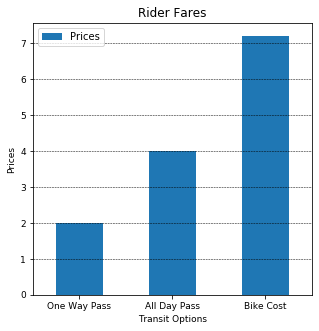

In [6]:
cost_comparison_df.Prices = pd.to_numeric(cost_comparison_df.Prices)
ax = cost_comparison_df.plot.bar(x='Transit Options', y='Prices', title ='Rider Fares', figsize=(5, 5), fontsize=9, rot=0)
ax.set_xlabel('Transit Options', fontsize=9)
ax.set_ylabel('Prices', fontsize=9)
ax.yaxis.grid(linestyle='--', linewidth='0.5', color='black')

# Save the Figure
plt.savefig('Rider Fares.png')

In [15]:
# Getting data from API, turning into json file
url = "https://municipal.systems/v1/places/az/dataTypes/shared-vehicle/data?key=f867b00f-7408-4c88-bd4d-ad4ef582b20c"
response2 = requests.get(url).json()
# Creating a .txt file to be read into a dataframe
with open('bike_data.txt', 'w') as outfile2:
    json.dump(response2, outfile2)
with open('bike_data.txt') as bike_file:
    dict_bike = json.load(bike_file)
# Turning json file into a readable dataframe
bike_data = pd.DataFrame.from_dict(json_normalize(dict_bike['results']), orient='columns')
bike_data.head()
# Creating editable dataframe, formatting column names
bike_data_df = bike_data
bike_data_df.columns = bike_data_df.columns.str.strip().str.lower().str.replace('data.','')
# Dropping unnecessary columns
bike_data_df = bike_data_df[['name','geometry.coordinates','operators',]]
# Removing brackets from operators values, then dropping JUMP LA rows
# Inserting error removal, the below .loc line provides a "warning" that is
# a false positive, the data is still correct and what we are looking for
# See http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# and https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
# For further information
pd.options.mode.chained_assignment = None  # default='warn'
bike_data_df.loc[:,'operators'] = bike_data_df['operators'].str.get(0)
bike_data_df = bike_data_df[bike_data_df.operators != 'JUMP LA']
# Removing brackets from geometry.coordinates, splitting into lat/lon columns
bike_data_df['coordinates'] = bike_data_df['geometry.coordinates'].astype(str).str.replace('\[|\]','')
# # # Creating lat/lon lists
lat = []
lon = []
for row in bike_data_df['coordinates']:
 lat.append(row.split(',')[1])
 lon.append(row.split(',')[0])
# appending lat and lon data to new columns in dataframe
bike_data_df['latitude'] = lat
bike_data_df['longitude'] = lon
# # Dropping unnecessary columns
bike_data_df = bike_data_df[['name','operators','latitude','longitude']]
# Creating new column with combined lat/lon for future reverse geocode call
bike_data_df['latlng'] = bike_data_df.apply(lambda row: '{},{}'.format(row['latitude'], row['longitude']), axis=1)
bike_data_df['latlng'] = bike_data_df['latlng'].str.strip()
bike_data_df.head()

,name,operators,latitude,longitude,latlng
0,T759,Grid Bike Share,33.41814,-111.938395,"33.41814,-111.938395"
1,GRID 2220,Grid Bike Share,33.46572,-112.089135,"33.46572,-112.089135"
2,GRID 190,Grid Bike Share,33.465703,-112.089142,"33.465703,-112.089142"
4,GRID 254,Grid Bike Share,33.447542999999996,-112.10143,"33.447542999999996,-112.10143"
5,T990,Grid Bike Share,33.416872,-111.920858,"33.416872,-111.920858"


In [16]:
bike_data_df['geocode_data'] =''
bike_data_df['city'] = ''
bike_data_df['country'] = ''
def reverse_geocode(latlng):
 result = {}
 url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng={0}'
 request = url.format(latlng)
 api_url = (request + '&key=' + api_key-YpsD8MFy2u8)
 data = requests.get(api_url).json()
 if len(data['results']) > 0:
     result = data['results'][0]
 return result
bike_data_df['geocode_data'] = bike_data_df['latlng'].map(reverse_geocode)
bike_data_df



# identify municipality and country data in the json that google sent back
def parse_city(geocode_data):
  if (not geocode_data is None) and ('address_components' in geocode_data):
      for component in geocode_data['address_components']:
          if 'locality' in component['types']:
              return component['long_name']
          elif 'postal_town' in component['types']:
              return component['long_name']
          elif 'administrative_area_level_2' in component['types']:
              return component['long_name']
          elif 'administrative_area_level_1' in component['types']:
              return component['long_name']
  return None
def parse_country(geocode_data):
  if (not geocode_data is None) and ('address_components' in geocode_data):
      for component in geocode_data['address_components']:
          if 'country' in component['types']:
              return component['long_name']
  return None

NameError: name 'api_key' is not defined

In [17]:
bike_data_df['city'] = bike_data_df['geocode_data'].map(parse_city)
bike_data_df['country'] = bike_data_df['geocode_data'].map(parse_country)
print(len(bike_data_df))
bike_data_df.head()

NameError: name 'parse_city' is not defined